# Test SALib for sensitivity analysis 

In [34]:
from SALib.sample import saltelli
from SALib.sample import latin
import SALib.sample.sobol as Ss
from SALib.analyze import sobol
from SALib.test_functions import Ishigami
import numpy as np
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline
import numpy as np
import scipy as sp # for inverse CDF (ppf) function for distributions
import matplotlib.pyplot as plt

In [35]:
# example problem
problem_1 = {
    'num_vars': 3,
    'names': ['x1', 'x2', 'x3'],
    'bounds': [[-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359],
               [-3.14159265359, 3.14159265359]]
}

param_values_1 = saltelli.sample(problem_1, 2**11)



Y_1 = Ishigami.evaluate(param_values_1)

C:\Users\jacky92\AppData\Local\Temp\ipykernel_20816\633714308.py:10: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values_1 = saltelli.sample(problem_1, 2**11)


In [36]:
param_values_1.shape

(16384, 3)

In [37]:
Y_1.shape

(16384,)

In [38]:
Si = sobol.analyze(problem_1, Y_1)

In [39]:
Si

{'S1': array([ 0.3033393 ,  0.44240635, -0.01550643]),
 'S1_conf': array([0.03815353, 0.04054895, 0.04007252]),
 'ST': array([0.55785266, 0.44231934, 0.24317264]),
 'ST_conf': array([0.05266802, 0.0313407 , 0.0189047 ]),
 'S2': array([[        nan, -0.00497775,  0.2537483 ],
        [        nan,         nan, -0.0003345 ],
        [        nan,         nan,         nan]]),
 'S2_conf': array([[       nan, 0.06176535, 0.06922005],
        [       nan,        nan, 0.04638754],
        [       nan,        nan,        nan]])}

In [40]:
# Define Sarah's rhythmic mRNA degradation model

def Sarah_rhythmic_mRNA(par):
    model_output = np.zeros(3)
    
    # simulation time interval
    t = np.linspace(0,700,701)
    # intial value
    x0 = 0;

    sol = odeint(ode_model,x0,t,args=(par,))
    # cubic interpolation 

    spl = CubicSpline(t,sol)
    t_int = np.linspace(600,648,2000)
    sol_int = spl(t_int)
    
    maxss = max(sol_int)
    minss = min(sol_int)
    
    t_max = np.argmax(sol_int)
    phase = t_int[t_max]
    # calculate total mRNA rhythmicity
    model_output[0] =  np.mean(sol_int);
    model_output[1] = (maxss-minss)/(maxss+minss)
    model_output[2] = np.mod(phase,24)*2*np.pi/24
    
    
    '''
    # plot
    plt.plot(t,sol,'--',label='ode sol')
    plt.scatter(t_int,sol_int,s=2*np.ones(len(t_int)),color='red',label='cubic interpolation')
    plt.scatter(phase,maxss,s=50,marker='^',color='green',label='peak phase')
    plt.grid()
    plt.xlim([600,648])
    plt.xlabel('phase(h)')
    plt.ylabel('[mRNA]')
    plt.legend()
    plt.show()
    '''
    return model_output[0],model_output[1],model_output[2]
    #return model_output

# ODE model of rhythmic mRNA degradation
def ode_model(x,t,p):

    Atrsc, Ptrsc, Kdgrd, Adgrd, Pdgrd = p

    omg = 2*np.pi/24

    Ktrsc = 1

    dxdt = Ktrsc*(1+Atrsc*np.cos(omg*(t-Ptrsc)))-Kdgrd*(1+Adgrd*np.cos(omg*(t-Pdgrd)))*x
    
    return dxdt

# Use Saltelli sampling scheme (AB sampling)

NumpyArray -> N x (2D + 2),  where N is sample size and D is the number of parameters.

C:\Users\jacky92\AppData\Local\Temp\ipykernel_20816\3151307831.py:15: DeprecationWarning: `salib.sample.saltelli` will be removed in SALib 1.5. Please use `salib.sample.sobol`
  param_values = saltelli.sample(problem, sample_size)


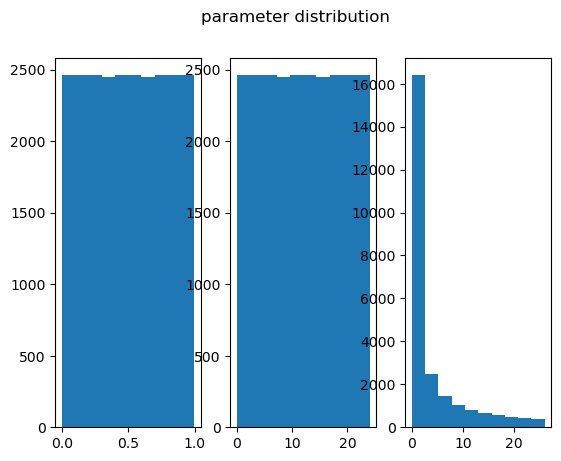

In [41]:
# Define the Model inputs distribution
problem = {
    'num_vars': 5,
    'names': ['Atrsc', 'Ptrsc', 'Kdgrd', 'Adgrd','Pdgrd'],
    'bounds': [[0, 1],
               [0, 24],
               [-1.58, 1.415],
               [0, 1],
               [0, 24]],
    'dists':['unif','unif','unif','unif','unif'],
    #'outputs': ['mean','amplitude','phase']
}

sample_size = 2**11
param_values = saltelli.sample(problem, sample_size)
#saltelli_param_values = saltelli.sample(problem, sample_size)
# be careful of the usage of Sobol sequence, details in the discussion 
# UserWarning: 
#        Convergence properties of the Sobol' sequence is only valid if
#        `N` (10000) is equal to `2^n`.

# use inverse CDF to transform Kd distribution
param_values[:,2] = 10**param_values[:,2]

# Kd distribution created in MATLAB
# Kd_pd_log= makedist('Uniform','lower',-1.58,'upper',1.415);
# Kd_pd = 10.^random(Kd_pd_log,[size,1]);


# plot the distribution of model parameters
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.suptitle('parameter distribution')
ax1.hist(param_values[:,0])
ax2.hist(param_values[:,1])
ax3.hist(param_values[:,2])
plt.show()

In [42]:
# Run Sarah model
Y = np.array([Sarah_rhythmic_mRNA(par) for par in param_values])

In [43]:
Y.shape

(24576, 3)

In [44]:
phase = Y[:,2]

In [45]:
phase.shape

(24576,)

In [46]:
# Sobol analysis for each output
sobol_indices = sobol.analyze(problem, phase)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

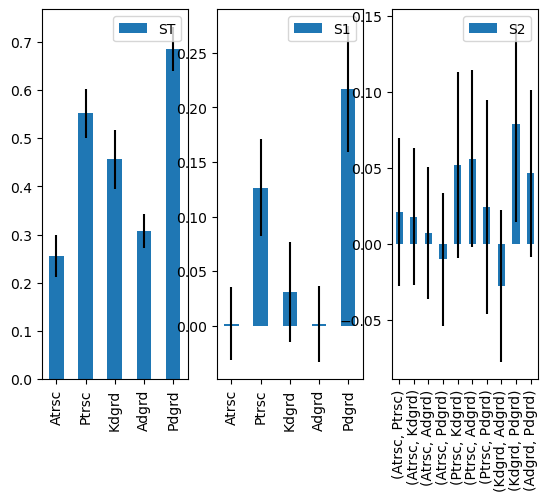

In [47]:
sobol_indices.plot()

# Use Sobol sequence sampling scheme 

NumpyArray -> [N x (2D + 2)], where N is sample size and D is the number of parameters.

In [58]:
sample_size_L = 2**11
param_values_L = Ss.sample(problem, sample_size_L)

In [59]:
# use inverse CDF to transform Kd distribution
param_values_L[:,2] = 10**param_values_L[:,2]

In [60]:
param_values_L.shape

(24576, 5)

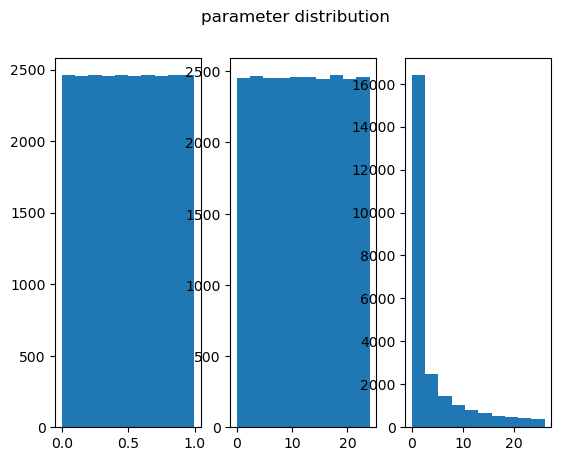

In [61]:
# plot the distribution of model parameters
fig, (ax1,ax2,ax3) = plt.subplots(1,3)
fig.suptitle('parameter distribution')
ax1.hist(param_values_L[:,0])
ax2.hist(param_values_L[:,1])
ax3.hist(param_values_L[:,2])
plt.show()

In [62]:
# Run Sarah model
Y_L = np.array([Sarah_rhythmic_mRNA(par) for par in param_values_L])

In [63]:
Y_L.shape

(24576, 3)

In [64]:
phase_L = Y_L[:,2]

In [65]:
phase_L.shape

(24576,)

In [66]:
# Sobol analysis for each output
sobol_indices_L = sobol.analyze(problem, phase_L)

array([<Axes: >, <Axes: >, <Axes: >], dtype=object)

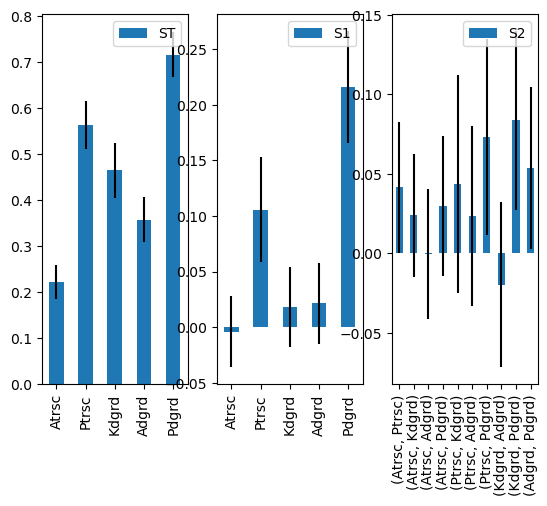

In [67]:
sobol_indices_L.plot()

# Testing Summary

After checking the manual of SALib, Saltelli & Sobol sampling schemes are compatible with Sobol analyze function, whereas Latin Hyper Cube is not. It calls for more careful investigation of the sampling scheme.